## Final Project Submission

Please fill out:
* Student name: Samuel Marder
* Student pace: Flex-20 week
* Scheduled project review date/time: 
* Instructor name: Matt Carr
* Blog post URL: https://medium.com/@samuel.s.marder/slight-right-onto-data-science-64912ef3bd67


# Overview

This project analyzes basic movie data to give Microsoft an idea on how to enter the market. Data analysis of various sources shows how different aspects affect the return on investment of the movie. This ranges from who should direct to the kind of film they should be making along with how long to make the film.

# Business Problem

Microsoft needs to figure out the best way to invest in the first movie as a studio. Through examination of data provided from IMDB and TN, I can show some good ways to invest capital in the first film.

# Data Analysis

In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
conn = sqlite3.connect("data/im.db")
sns.set(font_scale = 1)
pal = sns.color_palette("Blues", as_cmap=True)

First, I am gathering data for the movie directors

In [27]:
q = """SELECT p.primary_name AS director,
mb.primary_title
FROM persons AS p 
JOIN directors USING (person_id)
JOIN movie_basics AS mb USING (movie_id)"""
director_movie_df = pd.read_sql(q, conn).drop_duplicates()
director_movie_df.head()

,director,primary_title
0,Ruel S. Bayani,Paano na kaya
4,Ruel S. Bayani,No Other Woman
7,Ruel S. Bayani,One More Try
8,Ruel S. Bayani,Kasal
10,Bryan Beasley,The Quiet Philanthropist: The Edith Gaylord Story


In [28]:
director_movie_df.set_index('primary_title', inplace=True)
director_movie_df.head()

,director
primary_title,
Paano na kaya,Ruel S. Bayani
No Other Woman,Ruel S. Bayani
One More Try,Ruel S. Bayani
Kasal,Ruel S. Bayani
The Quiet Philanthropist: The Edith Gaylord Story,Bryan Beasley


Second, I am pulling information about the runtime and genre of each movie

In [29]:
q = """SELECT mb.primary_title,
mb.runtime_minutes,
mb.genres
FROM movie_basics as mb"""
movie_df = pd.read_sql(q, conn).drop_duplicates()
movie_df.head()

,primary_title,runtime_minutes,genres
0,Sunghursh,175.0,"Action,Crime,Drama"
1,One Day Before the Rainy Season,114.0,"Biography,Drama"
2,The Other Side of the Wind,122.0,Drama
3,Sabse Bada Sukh,NaN,"Comedy,Drama"
4,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy"


In [30]:
#Bining up runtime
def bin_runtime(rt):
    if(rt <= 30):
        return "0 to 30"
    elif(rt <= 60):
        return "30 to 60"
    elif(rt <= 90):
        return "60 to 90"
    elif(rt <= 120):
        return "90 to 120"
    elif(rt <= 150):
        return "120 to 150"
    else:
        return "150+"

In [31]:
movie_df['genres'] = movie_df['genres'].str.split(pat=",")
movie_df['runtime_bins'] = movie_df['runtime_minutes'].apply(bin_runtime)
movie_df.set_index("primary_title", inplace=True)
movie_df.head()

,runtime_minutes,genres,runtime_bins
primary_title,,,
Sunghursh,175.0,"[Action, Crime, Drama]",150+
One Day Before the Rainy Season,114.0,"[Biography, Drama]",90 to 120
The Other Side of the Wind,122.0,[Drama],120 to 150
Sabse Bada Sukh,NaN,"[Comedy, Drama]",150+
The Wandering Soap Opera,80.0,"[Comedy, Drama, Fantasy]",60 to 90


In [32]:
genre_df = movie_df.explode('genres')
genre_df.head()

,runtime_minutes,genres,runtime_bins
primary_title,,,
Sunghursh,175.0,Action,150+
Sunghursh,175.0,Crime,150+
Sunghursh,175.0,Drama,150+
One Day Before the Rainy Season,114.0,Biography,90 to 120
One Day Before the Rainy Season,114.0,Drama,90 to 120


## Create a dataframe for movie budgets

I chose to read in the movie budgets csv file to find that the information in it was very string based. With some help from Yoni, I was able to clean the strings away in favor of numbers so I could calculate the ROI. I also stripped away all information that was not related to ROI to make merging and aggregation easier.

In [33]:
mb_df = pd.read_csv("data/tn.movie_budgets.csv")
mb_df = mb_df.set_index('movie')

mb_df['production_budget'].replace(to_replace=r'\D', value=r'', regex=True, inplace=True)
mb_df['production_budget'] = mb_df['production_budget'].astype(int)

mb_df['domestic_gross'].replace(to_replace=r'\D', value=r'', regex=True, inplace=True)
mb_df['domestic_gross'] = mb_df['domestic_gross'].astype(int)

mb_df['worldwide_gross'].replace(to_replace=r'\D', value=r'', regex=True, inplace=True)
mb_df['worldwide_gross'] = mb_df['worldwide_gross'].astype(float) #Turns out, int is too small here

mb_df['roi'] = mb_df['domestic_gross'] + mb_df['worldwide_gross'] - mb_df['production_budget'] 

mb_df.drop(columns = ['id', 'release_date', 'production_budget', 'domestic_gross', 'worldwide_gross'], inplace=True)

mb_df.head()

,roi
movie,
Avatar,3.111853e+09
Pirates of the Caribbean: On Stranger Tides,8.761278e+08
Dark Phoenix,-1.574753e+08
Avengers: Age of Ultron,1.531420e+09
Star Wars Ep. VIII: The Last Jedi,1.619903e+09


## Create and visualize Director ROI Dataframe
I pulled data together from the movie budgets and director movie data frames so I can aggregate an average ROI based on the director of the film in question.

In [55]:
director_roi_df = mb_df.join(director_movie_df, how="inner")
director_roi_df = director_roi_df.groupby(['director']).mean()
director_roi_df.sort_values(['roi'], ascending=False, inplace=True)
director_roi_df.reset_index(inplace=True)
director_roi_df

,director,roi
0,Atsushi Wada,3.111853e+09
1,Kevin Lincoln,2.667572e+09
2,Pete Meads,2.667572e+09
3,Ravi Punj,2.667572e+09
4,Adam Green,1.523208e+09
...,...,...
3236,Terry George,-7.122430e+07
3237,Zeljko Mirkovic,-7.122430e+07
3238,Candy J. Beard,-7.122430e+07
3239,Simon Wells,-8.905748e+07


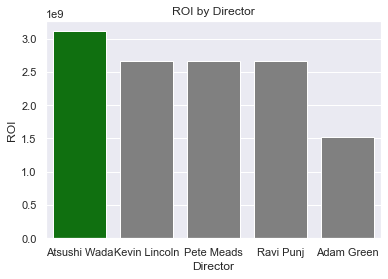

In [59]:
f, ax = plt.subplots()
clrs = ['grey' if (x < max(director_roi_df['roi'])) else 'green' for x in director_roi_df['roi']]
sns.barplot(x="director", y="roi", data=director_roi_df.head(), palette=clrs)
ax.set(xlabel="Director", ylabel="ROI", title="ROI by Director");
plt.savefig("./images/Director_ROI.png")

## Create and visualize the Genre ROI Dataframe
I create the genre ROI data frame much like I did director but aggregating on genres instead of director

In [36]:
genre_roi_df = mb_df.join(genre_df, how="inner")
genre_roi_df = genre_roi_df.groupby(['genres']).mean()
genre_roi_df.sort_values(['roi'], ascending=False, inplace=True)
genre_roi_df.reset_index(inplace=True)

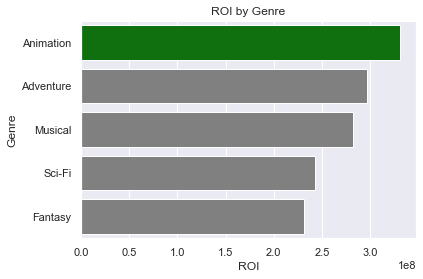

In [60]:
f, ax = plt.subplots()
clrs = ['grey' if (x < max(genre_roi_df['roi'])) else 'green' for x in genre_roi_df['roi']]
sns.barplot(x="roi", y="genres", data=genre_roi_df.head(), palette=clrs)
ax.set(ylabel="Genre", xlabel="ROI", title="ROI by Genre")
plt.savefig('./images/Genre_ROI.png');

## Create and visualize Runtime ROI Dataframe
For the final data frame, I combine the movie budget dataframe with the movie dataframe.

In [66]:
rt_roi_df = mb_df.join(movie_df, how="inner")
rt_roi_df.dropna(subset=["runtime_minutes"], inplace=True) #Removing ~400 movies with no runtime
rt_roi_df = rt_roi_df.groupby(['runtime_bins']).mean()
rt_roi_df.sort_values(['roi'], ascending=False, inplace=True)
rt_roi_df.reset_index(inplace=True)

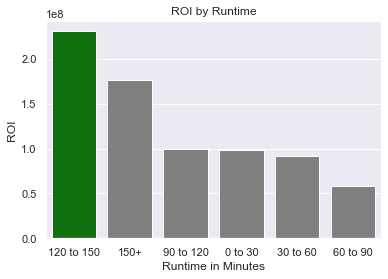

In [67]:
f, ax = plt.subplots()
clrs = ['grey' if (x < max(rt_roi_df['roi'])) else 'green' for x in rt_roi_df['roi']]
sns.barplot(x="runtime_bins", y="roi", data=rt_roi_df, palette=clrs);
ax.set(xlabel="Runtime in Minutes", ylabel="ROI", title="ROI by Runtime")
plt.savefig('./images/Runtime_ROI.png');

# Recommendations:
1. Do an animated film
2. Hire Atsushi Wada to direct
3. The best seems to be around 120 to 150 minutes in runtime

# Next steps
* One flaw is my methods can be misleading by the number of observations in each bin i.e. Mr Wada may have made one outstanding film while Mr Lincoln has more stable ROI in comparison, additional analysis might be able to negate this flaw
* Further analysis could be done to provide a more comprehensive crew such as writers and actors from the IMDB sqlite db